<a href="https://colab.research.google.com/github/LorenzoTarricone/Advnced-Programming-and-Optimization-Algorithm/blob/main/Tarricone4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🚗 ASSIGNMENT 4 🔋

We have a vehicle which needs to pass a known test track. You are given values $Preq(t)$ for each time $t=1,...,T$ which the vehicle's wheels needs to exert in order to successfully pass this test track.

The vehicle has a combustion engine, a motor/generator connected to a battery, and a friction break. Motor/generator can act either as a motor when it uses energy stored in the battery to power the wheels, or as a generator when it extracts the power from the wheels (regenerative breaking) or the engine to store it in the battery.

$Preq(t)$ is positive when the wheels need power, e.g. vehicle is ascending a hill or accelerating: power for the wheels needs to be provided by the combustion engine and/or the motor/generator which extracts the power stored in the battery. When $Preq(t)$ is negative (e.g. because vehicle is descending a hill), the power is extracted by the motor/generator which can store it in the battery and/or by the friction break.

Power is conserved, i.e., at each time $t$, we have
$Preq(t) = Peng(t) + Pmg(t) - Pbr(t)$
where $0≤Peng(t)≤Peng_{max}$ is power produced by the combustion engine, $Pmg_{min} ≤ Pmg(t) ≤ Pmg_{max}$ is power produced by the motor/generator (can be also negative if motor/generator absorbs power to charge the battery) and $Pbr(t)≥0$ is the power absorbed by the friction break. See data bellow for the definition of the constants.

For every $t=1,...,T+1$, the energy $E(t)$ in the battery has to be between $0$ and $Ebatt_{max}$ representing the power stored in empty and full battery respectively. Moreover, we need to take into account the charging and discharging of the battery: we have
$E(t+1) = E(t) - Pmg(t) - η|Pmg(t)|, for t=1,...,T,$
see variable eta in the data. The term with coefficient η represents the energy lost due to the inefficiency of the battery and motor/generator. We also require $E(T+1)=E(1)$ to make a fair comparison with a non-hybrid vehicle which has no battery.

The objective is to minimize the total fuel consumption of the vehicle over time, where the consumption at time $t$ is given by formula $Peng(t) + γ(Peng(t))^2$, i.e., a quadratic function. See data for the value of $γ$.

###Task 1: formulate this minimization problem as a convex program (10 points)
It is almost convex, just one set of constraints is problematic. Hint: Try to relax it, only one inequality is important, but provide an explanation (e.g. in the comments of your code) why your formulation is equivalent.

###Task 2: solve your convex program with cvxpy library (10 points)
Link to the library: https://www.cvxpy.org/. Present the solution using a clear and well explained plot generated by matplotlib which was also used in the previous assignment.

###Task 3: comparison with a battery-less car (5 points)
Change $Ebatt_{max}$ to $0$ and solve your program again to see how does it affect the power consumption.

###Task 4: handle glitches (5 points)
You may find out that although your program is equivalent, the solution found by the solver does not fulfill all the relaxed constraints with equality. This might happen during long periods of breaking when there is a lot of opportunities to charge the battery and sometimes the solver may decide to waste part of the power available to charge the battery (because it may charge it fully in the following time steps). There are two options how to proceed:

- Postprocess the solution to get another solution with the same objective value where the relaxed constraints are preserved with equality. Such solution must exist since your program is equivalent to the original one. Hint: just move all the power from motor/generator to the battery and, if the battery is full, move it to the friction break.

- Add a small term to the objective which will discourage such situation: for every $t=1,...,T$, you can add a term $ε·max(0, -Pmg(t))$ for some small positive $ε$ in order to discourage absorbing power by the motor/generator if it is not going to be used for charging the battery (because it is cheaper to absorb the power using the friction break)
In case you decide to modify the objective, compare the power consumption achieved by your program to the power consumption achieved by the program with the original objective (to show that they are very similar with your choice of $ε$.

###Data
Include the following code in your solution which generates data for you. The array Preq contains power requirements in all time steps. Bellow, are the bounds specifying the parameters of the engine, motor/generator, capacity of the battery, coefficient eta of the inefficiency of charging/discharging and coefficient gamma in the objective function.

```
import numpy as np
a=[0.5, -0.5, 0.2, -0.7, 0.6, -0.2, 0.7, -0.5, 0.8, -0.4]
l=[40, 20, 40, 40, 20, 40, 30, 40, 30, 60]
Preq=np.arange(a[0],a[0]*(l[0]+0.5),a[0])

for i in range(1, len(l)):
    Preq=np.r_[ Preq, np.arange(Preq[-1]+a[i],Preq[-1]+a[i]*(l[i]+0.5),a[i]) ]

T = sum(l)

Peng_max = 20.0
Pmg_min = -6.0
Pmg_max = 6.0
Ebatt_max = 100.0
eta = 0.1
gamma = 0.1
```

####A note on precision
LP solvers which we used so far always provided a precise feasible solutions. This is not always the case with the solvers for convex optimization. If you want better precision, see "eps" parameters in Solver options. However, default values are good enough for the purpose of this assignment.


---

##Task 1: Formulating the convex problem 

Our optimization problem is almost a convex problem. The only issue is inside the equation regulating the change of battery from time $t$ to time $t+1$ because it contains an absolute value and to solve it we will apply a standard relaxation, letting this constraint define a convex region.

Heuristically, we want to impose the battery to disharge when the electric motor/generator is used and we do not force it to recharge when it it should. This second istance will be still satisfied by the solver because (even intuitively) we want to keep the battery level as high as possible. Remember: a non empty battery means that we can use the electic motor/generator and therefore not the combustion engine, reducing therefore our objective value. Mathematically this means:
$$E(t+1) = E(t) - P_{mg}(t) - \eta |P_{mg}(t)| \quad  \forall t$$ 
$$⇓$$
$$E(t+1) \leqslant E(t) - P_{mg}(t) - \eta P'_{mg}(t)\quad  \forall t$$ 
$$P'_{mg}(t) \geqslant - P_{mg}(t)\quad \forall t$$
$$P'_{mg}(t) \geqslant  P_{mg}(t)\quad  \forall t$$

This leads us to this final form for our optimization problem:
$$\begin{aligned}
\min \quad & \sum_{t=1}^{T}P_{eng}(t) + \gamma (P_{eng})^2\\
\textrm{s.t.} \quad & P_{req} = P_{eng} + P_{mg} - P_{br}\\
  & E(t+1) \leqslant E(t) - P_{mg}(t) - \eta P'_{mg}(t)  \\
  & P'_{mg}(t) \geqslant - P_{mg}(t)\\
  & P'_{mg}(t) \geqslant  P_{mg}(t)\\
  & 0 \leqslant P_{eng}(t) \leqslant P_{eng max}(t) \\ 
  & P_{mg min}(t) \leqslant P_{mg}(t) \leqslant P_{mg max}(t) \\ 
  & P_{br}(t) \geqslant 0 \\
  & 0 \leqslant E(t) \leqslant E_{battmax}(t) \\
  & \forall t \in{1...T}\\
\end{aligned}$$

##Task 2: Solving the problem and plotting the results

In [ ]:
#We use this ready-made chunk of code to generate the data
import numpy as np
import cvxpy as cp

a=[0.5, -0.5, 0.2, -0.7, 0.6, -0.2, 0.7, -0.5, 0.8, -0.4]
l=[40, 20, 40, 40, 20, 40, 30, 40, 30, 60]
P_req=np.arange(a[0],a[0]*(l[0]+0.5),a[0])

for i in range(1, len(l)):
    P_req=np.r_[ P_req, np.arange(P_req[-1]+a[i],P_req[-1]+a[i]*(l[i]+0.5),a[i]) ]

T = sum(l)

P_eng_max = 20.0
P_mg_min = -6.0
P_mg_max = 6.0
E_batt_max = 100.0
eta = 0.1
gamma = 0.1


In [ ]:
#We define the variables needed for the problem 
P_eng = cp.Variable(T)
P_mg = cp.Variable(T)
P_aux_mg = cp.Variable(T)
P_br = cp.Variable(T)
E = cp.Variable(T+1)

In [ ]:
from cvxpy.problems.objective import Minimize
#We define the cost function and the costraints
cost = 0
constraints = []

constraints += [E[T] == E[0]]

for t in range(T):
  cost += cp.sum(P_eng[t] + gamma * cp.square(P_eng[t]))
  constraints += [ P_req[t] == P_eng[t] + P_mg[t] - P_br[t],
                   E[t+1] <= E[t] - P_mg[t] - eta * P_aux_mg[t],
                   P_aux_mg[t] >= - P_mg[t],
                   P_aux_mg[t] >= P_mg[t],
                   P_eng[t] <= P_eng_max,
                   P_eng[t] >= 0,
                   P_mg[t] <= P_mg_max,
                   P_mg[t] >= P_mg_min,
                   P_br >= 0,
                   E[t] <= E_batt_max,
                   E[t] >= 0]               


#We solve the problem
problem = cp.Problem(cp.Minimize(cost), constraints)
problem.solve(solver=cp.ECOS)


5077.526419404248

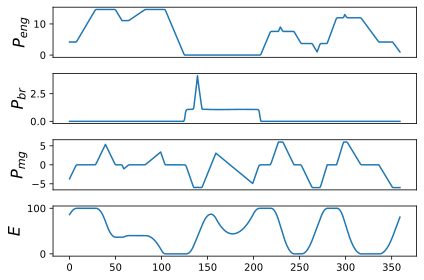

In [ ]:
#We plot the results

#N.B. we round the results just because we don't want to plot very small 
#fluctuations around zero due to the numerical solver

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

f = plt.figure()

# Plot P_eng.
ax = f.add_subplot(411)
plt.plot(P_eng[:].value.round(3))
plt.ylabel(r"$P_{eng}$", fontsize=16)
plt.xticks([])


# Plot P_br.
plt.subplot(4,1,2)
x1 = P_br[:].value.round(3)
plt.plot(x1)
plt.ylabel(r"$P_{br}$", fontsize=16)
plt.xticks([])


# Plot P_mg.
plt.subplot(4,1,3)
plt.plot(P_mg[:].value.round(3))
plt.ylabel(r"$P_{mg}$", fontsize=16)
plt.xticks([])


# Plot E
plt.subplot(4,1,4)
x2 = E[:360].value.round(3)
plt.plot(range(360), x2)
plt.ylabel(r"$E$", fontsize=16)
plt.tight_layout()


plt.show()



##Task 3: comparison with a battery-less car

In [ ]:
#We use this ready-made chunk of code to generate the data
import numpy as np
import cvxpy as cp
from cvxpy.problems.objective import Minimize

a=[0.5, -0.5, 0.2, -0.7, 0.6, -0.2, 0.7, -0.5, 0.8, -0.4]
l=[40, 20, 40, 40, 20, 40, 30, 40, 30, 60]
P_req=np.arange(a[0],a[0]*(l[0]+0.5),a[0])

for i in range(1, len(l)):
    P_req=np.r_[ P_req, np.arange(P_req[-1]+a[i],P_req[-1]+a[i]*(l[i]+0.5),a[i]) ]

T = sum(l)

P_eng_max = 20.0
P_mg_min = -6.0
P_mg_max = 6.0
#As required the maximum capacity of the battery is now zero
E_batt_max = 0.0
eta = 0.1
gamma = 0.1

#We define the variables needed for the problem 
P_eng = cp.Variable(T)
P_mg = cp.Variable(T)
P_aux_mg = cp.Variable(T)
P_br = cp.Variable(T)
E = cp.Variable(T+1)


#We define the cost function and the costraints
cost = 0
constraints = []

constraints += [E[T] == E[0]]

for t in range(T):
  cost += cp.sum(P_eng[t] + gamma * cp.square(P_eng[t]))
  constraints += [ P_req[t] == P_eng[t] + P_mg[t] - P_br[t],
                   E[t+1] <= E[t] - P_mg[t] - eta * P_aux_mg[t],
                   P_aux_mg[t] >= - P_mg[t],
                   P_aux_mg[t] >= P_mg[t],
                   P_eng[t] <= P_eng_max,
                   P_eng[t] >= 0,
                   P_mg[t] <= P_mg_max,
                   P_mg[t] >= P_mg_min,
                   P_br >= 0,
                   E[t] <= E_batt_max,
                   E[t] >= 0]               


#We solve the problem
problem = cp.Problem(cp.Minimize(cost), constraints)
problem.solve(solver=cp.ECOS)

5896.80899889336

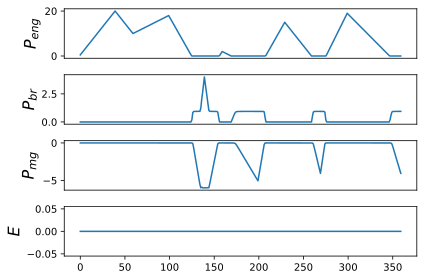

In [ ]:
#We plot the results

#N.B. we round the results just because we don't want to plot very small 
#fluctuations around zero due to the numerical solver

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

f = plt.figure()

# Plot P_eng.
ax = f.add_subplot(411)
plt.plot(P_eng[:].value.round(3))
plt.ylabel(r"$P_{eng}$", fontsize=16)
plt.xticks([])

# Plot P_br.
plt.subplot(4,1,2)
x1 = P_br[:].value.round(3)
plt.plot(x1)
plt.ylabel(r"$P_{br}$", fontsize=16)
plt.xticks([])

# Plot P_mg.
plt.subplot(4,1,3)
plt.plot(P_mg[:].value.round(3))
plt.ylabel(r"$P_{mg}$", fontsize=16)
plt.xticks([])


# Plot E
plt.subplot(4,1,4)
x2 = E[:360].value.round(3)
plt.plot(range(360), x2)
plt.ylabel(r"$E$", fontsize=16)
plt.tight_layout()


plt.show()

##Task 4: handle glitches

As you can see in the graph plottet just above we have a conceptual and computational problem. $P_{mg}$ is not costantly equal to zero even if we do not have a battery (the graph of $E$ is indeed flat).
Our relaxation here is failing because in theory if we use the generator/electric motor to absorb energy (negative values of $P_{mg}$), we would need to see the battery recharging, but we don't have battery tho. This problem is due to the fact that when the energy required at some time $t$ is negative we can both use the brake ($P_{br}$) or use the generator/ electric motor ($P_{mg}$). 

Given that we do not want the generator to come in action what we we will do is simply to add a small term in the objective function with the aim of discourageing the use of this. This term will be controlled by an additional parameter $\epsilon$ that will be arbitrarily small and this will lead us to obtain almost the same objective value.

In [ ]:
#We use this ready-made chunk of code to generate the data
import numpy as np
import cvxpy as cp
from cvxpy.problems.objective import Minimize

a=[0.5, -0.5, 0.2, -0.7, 0.6, -0.2, 0.7, -0.5, 0.8, -0.4]
l=[40, 20, 40, 40, 20, 40, 30, 40, 30, 60]
P_req=np.arange(a[0],a[0]*(l[0]+0.5),a[0])

for i in range(1, len(l)):
    P_req=np.r_[ P_req, np.arange(P_req[-1]+a[i],P_req[-1]+a[i]*(l[i]+0.5),a[i]) ]

T = sum(l)

P_eng_max = 20.0
P_mg_min = -6.0
P_mg_max = 6.0
E_batt_max = 0.0
eta = 0.1
gamma = 0.1

#New parameter epsilon
epsilon = 0.001

#We define the variables needed for the problem 
P_eng = cp.Variable(T)
P_mg = cp.Variable(T)
P_aux_mg = cp.Variable(T)
P_br = cp.Variable(T)
E = cp.Variable(T+1)


#We define the cost function and the costraints
cost = 0
constraints = []

constraints += [E[T] == E[0]]

for t in range(T):
  #We add the discouraging factor in the objective 
  cost += cp.sum(P_eng[t] + gamma * cp.square(P_eng[t]) + epsilon * cp.maximum(0, - P_mg[t]))
  constraints += [ P_req[t] == P_eng[t] + P_mg[t] - P_br[t],
                   E[t+1] <= E[t] - P_mg[t] - eta * P_aux_mg[t],
                   P_aux_mg[t] >= - P_mg[t],
                   P_aux_mg[t] >= P_mg[t],
                   P_eng[t] <= P_eng_max,
                   P_eng[t] >= 0,
                   P_mg[t] <= P_mg_max,
                   P_mg[t] >= P_mg_min,
                   P_br >= 0,
                   E[t] <= E_batt_max,
                   E[t] >= 0]                 


#We solve the problem
problem = cp.Problem(cp.Minimize(cost), constraints)
problem.solve(solver=cp.ECOS)

5896.80900642449

$\Uparrow$ As you can see this output is just some decimals different to the one previously obtained without the correction $\Uparrow$


Let's now graphically check the result obtained:

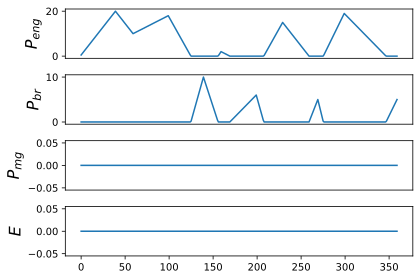

In [ ]:
#We plot the results

#N.B. we round the results just because we don't want to plot very small 
#fluctuations around zero due to the numerical solver

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

f = plt.figure()

# Plot P_eng.
ax = f.add_subplot(411)
plt.plot(P_eng[:].value.round(3))
plt.ylabel(r"$P_{eng}$", fontsize=16)
plt.xticks([])

# Plot P_br.
plt.subplot(4,1,2)
x1 = P_br[:].value.round(3)
plt.plot(x1)
plt.ylabel(r"$P_{br}$", fontsize=16)
plt.xticks([])

# Plot P_mg.
plt.subplot(4,1,3)
plt.plot(P_mg[:].value.round(3))
plt.ylabel(r"$P_{mg}$", fontsize=16)
plt.xticks([])

# Plot E
plt.subplot(4,1,4)
x2 = E[:360].value.round(3)
plt.plot(range(360), x2)
plt.ylabel(r"$E$", fontsize=16)
plt.tight_layout()


plt.show()

Now it really looks like the graph of a battery less car 😁